# Example notebook: Pareto Front

In this notebook we demonstrate basic usage of the portfolio optimization module and show how results can be visualized in the form of a pareto front.

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dwave.samplers import SimulatedAnnealingSampler
from tno.quantum.problems.portfolio_optimization import (
    PortfolioOptimizer,
    plot_front,
    plot_points,
)

## Load benchmark data

In [2]:
# Load benchmark data and classical Pareto front solutions
with Path("classical_solutions_for_benchmark_dataset.json").open(
    encoding="utf-8"
) as json_file:
    json_data = json.load(json_file)

    # Reconstruct portfolio data
    portfolio_data = pd.DataFrame(
        data=json_data["portfolio_data"]["data"],
        columns=json_data["portfolio_data"]["columns"],
    )

    # Reconstruct classical Pareto frontier solutions
    x1_classical = json_data["classical_solution"]["constrained"]["x"]
    y1_classical = json_data["classical_solution"]["constrained"]["y"]
    x2_classical = json_data["classical_solution"]["unconstrained"]["x"]
    y2_classical = json_data["classical_solution"]["unconstrained"]["y"]

portfolio_data.head()

,asset,outstanding_now,min_outstanding_future,max_outstanding_future,emis_intens_now,emis_intens_future,income_now,regcap_now
0,Sector 1 - Country 1,10.2,14,19,10.0,7.6,5,5
1,Sector 2 - Country 1,600.0,473,528,80.0,60.8,70,40
2,Sector 3 - Country 1,20.0,24,28,30.0,22.8,5,10
3,Sector 4 - Country 1,800.0,1090,1410,5.0,3.8,1,2
4,Sector 5 - Country 1,40.0,56,74,5.0,3.8,10,5


## Create Portfolio Optimization problem instance

In [3]:
# Choose QUBO sampler
sampler = SimulatedAnnealingSampler()
sampler_kwargs = {"num_reads": 20, "num_sweeps": 200}

In [4]:
# Set up penalty coefficients for the constraints
lambdas1 = np.logspace(-16, 1, 25, endpoint=False, base=10.0)
lambdas2 = np.logspace(-16, 1, 25, endpoint=False, base=10.0)
lambdas3 = np.array([1])

In [5]:
# Define the portfolio optimization problem
portfolio_optimizer = PortfolioOptimizer(portfolio_data=portfolio_data, k=2)
portfolio_optimizer.add_minimize_hhi(weights=lambdas1)
portfolio_optimizer.add_maximize_roc(formulation=1, weights_roc=lambdas2)
portfolio_optimizer.add_emission_constraint(
    weights=lambdas3,
    emission_now="emis_intens_now",
    emission_future="emis_intens_future",
    name="emission",
)

In [6]:
# Solve the portfolio optimization problem
results = portfolio_optimizer.run(sampler, sampler_kwargs)
results.head()

Total outstanding now: 21252.70
ROC now: 1.0642
HHI now: 1.0000
Total Emission now: 43355508.00
Relative emission intensity now: 2040.00
Expected total outstanding future: 31368.00 Std dev: 886.39
Expected average growth factor: 1.4760 Std dev: 0.0417
Status: creating model
Emission constraint: emission, target reduction percentage: -30.0%
Status: calculating


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:24<00:00, 25.14it/s]

Drop duplicate samples in results.
Number of unique samples:  12500
Time consumed: 0:00:24.911691
                                  outstanding amount  diff ROC  \
0  (15.666666666666666, 528.0, 24.0, 1410.0, 68.0...  2.594832   
1  (19.0, 473.0, 26.666666666666668, 1410.0, 62.0...  1.955259   
2  (14.0, 491.3333333333333, 28.0, 1410.0, 56.0, ...  2.741633   
3  (15.666666666666666, 473.0, 24.0, 1303.3333333...  3.238665   
4  (14.0, 491.3333333333333, 25.333333333333332, ...  2.928683   

   diff diversification  diff outstanding  diff emission  
0             -6.388219          1.533217     -30.000089  
1             -6.960042          1.533139     -30.000082  
2             -6.306241          1.531162     -29.999963  
3             -6.986165          1.538110     -30.000022  
4             -2.567819          1.501096     -30.000039  


## Visualize results

In [44]:
tolerance = 0.00001
points_constraints_met, points_constraints_violated = results.slice_results(tolerance=tolerance)
x1, y1 = points_constraints_met
x2, y2 = points_constraints_violated

print(f"{len(x1)}/{len(results)} data points satsify the emission constraint given a tolerance of {tolerance:.3%}.")

12500/12500 data points satsify the emission constraint given a tolerance of 0.001%.


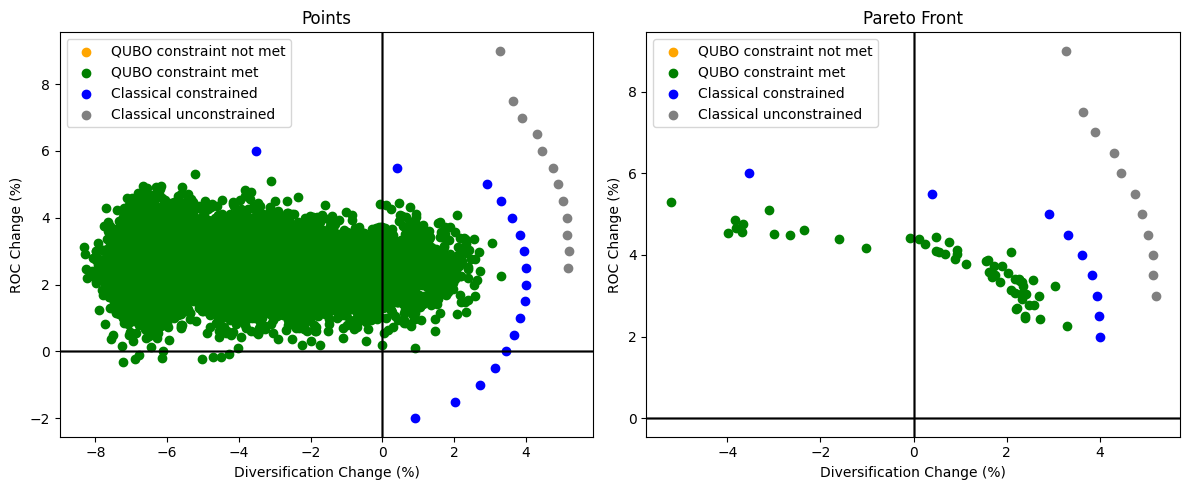

In [45]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
colors = ["orange", "green", "blue", "gray"]
labels = ["QUBO constraint not met", "QUBO constraint met"]
labels += ["Classical constrained", "Classical unconstrained"]
x_values = [x2, x1, x1_classical, x2_classical]
y_values = [y2, y1, y1_classical, y2_classical]

for x_val, y_val, color, label in zip(x_values, y_values, colors, labels):
    plot_points(x_val, y_val, color=color, label=label, ax=ax1)
    plot_front(x_val, y_val, color=color, label=label, ax=ax2)
    
ax1.set_title("Points")
ax2.set_title("Pareto Front")
fig.tight_layout()